In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, KernelPCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics.pairwise import *

from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression

# add ./utlities/ to path
import sys
sys.path.insert(0, './utilities/')
from MF import *


In [2]:
def get_feature_matrix(masstime, data, significant=True):
    if not significant:
        return data.iloc[3:,8:].to_numpy(dtype=float).T
    inds=[]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.unique(np.asarray(inds, dtype=int))
    return data.iloc[inds,8:].to_numpy(dtype=float).T

def get_features(masstime, data, significant=True):
    if not significant:
        return data
    inds=[0,1,2]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.unique(np.asarray(inds, dtype=int))
    return data.iloc[inds,:]


def get_ids(data):
    ID=[]
    for line in data.iloc[2,8:]:
        ID.append(line.split('_')[-1].split('.')[0])
    return np.array(ID)

def add_noise(x, magnitude):
    return x + np.random.normal(0,magnitude, x.shape)

def make_oneWay_design(covariates):
    LE = LabelEncoder()
    codes = LE.fit_transform(covariates)
    levels = np.unique(codes)
    k = len(levels)
    n = len(codes)
    
    design = np.zeros((n,k))
    mapping = []
    for j in range(k):
        for i in range(n):
            mapping.append(levels[j])
            design[i,j] = (codes[i]==levels[j])
            
    return design, LE.inverse_transform(levels)

In [3]:
path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
#path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.5MINVAR0.250/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
filenames_s

['cellshilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPposALPHA0.05FC1.0MINVAR0.125.csv']

In [4]:
path = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenames = [line.split('\n')[0] for line in open(path + "filenames.txt")]
filenames

['cellshilicnegGFstatus.csv',
 'cellshilicposGFstatus.csv',
 'cellslipidnegGFstatus.csv',
 'cellslipidposGFstatus.csv',
 'cellsRPnegGFstatus.csv',
 'cellsRPposGFstatus.csv',
 'mediumhilicnegGFstatus.csv',
 'mediumhilicposGFstatus.csv',
 'mediumRPnegGFstatus.csv',
 'mediumRPposGFstatus.csv']

### Get significant features with GAP status

In [46]:
fnum=7
pathGF = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
data = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_significance = pd.read_csv(path_s + filenames_s[fnum],sep=';')

masstime = np.unique(df_significance[' masstime'].to_numpy())
significant_features = get_features(masstime, data, True)
x1 = significant_features.iloc[3:,8:48].to_numpy(dtype=float).T
x_all = data.iloc[3:,8:48].to_numpy(dtype=float).T
ID=get_ids(data.iloc[:,:48])

print("{} significant features".format(len(masstime)))

mediumhilicposGFstatus.csv
mediumhilicposALPHA0.05FC1.0MINVAR0.125.csv
29 significant features


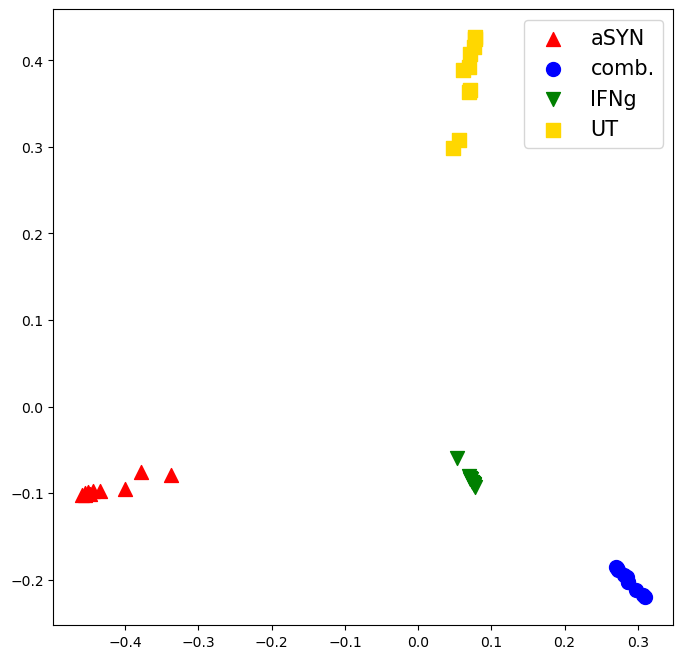

In [84]:
K = rbf_kernel(x1)
# center the kernel matrix
one_n = np.ones((K.shape[0],K.shape[0])) / K.shape[0]
K = K - one_n @ K - K @ one_n + one_n @ K @ one_n
# do kernel PCA
vals, vecs = np.linalg.eig(K)
inds = np.argsort(vals)[::-1]
vals = vals[inds]
vecs = vecs[:,inds]
# scale eigenvectors
alpha = vecs / np.sqrt(vals)
# project data
pca = K @ alpha[:,:2]
#C = np.linalg.cholesky(K + 1e-12*np.eye(K.shape[0]))
#pca = C @ alpha[:,:2]

# Use ridge regression to predict pca from C 
ridge_model1 = ElasticNet(alpha=0.2, warm_start=True, l1_ratio=0.2, fit_intercept=False).fit(K, pca[:,0])
ridge_model2 = ElasticNet(alpha=0.2, warm_start=True, l1_ratio=0.2, fit_intercept=False).fit(K, pca[:,1])
beta1 = ridge_model1.coef_
beta2 = ridge_model2.coef_
pca = K @ np.vstack((beta1,beta2)).T

k=0
kk=1
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pca[:10,k],pca[:10,kk], marker='^', c='red', s=100)
ax.scatter(pca[10:20,k],pca[10:20,kk], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,k],pca[20:30,kk], marker='v', c='green', s=100)
ax.scatter(pca[30:,k],pca[30:,kk], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','IFNg','UT'], fontsize=15)


In [22]:
beta.shape

(2, 40)

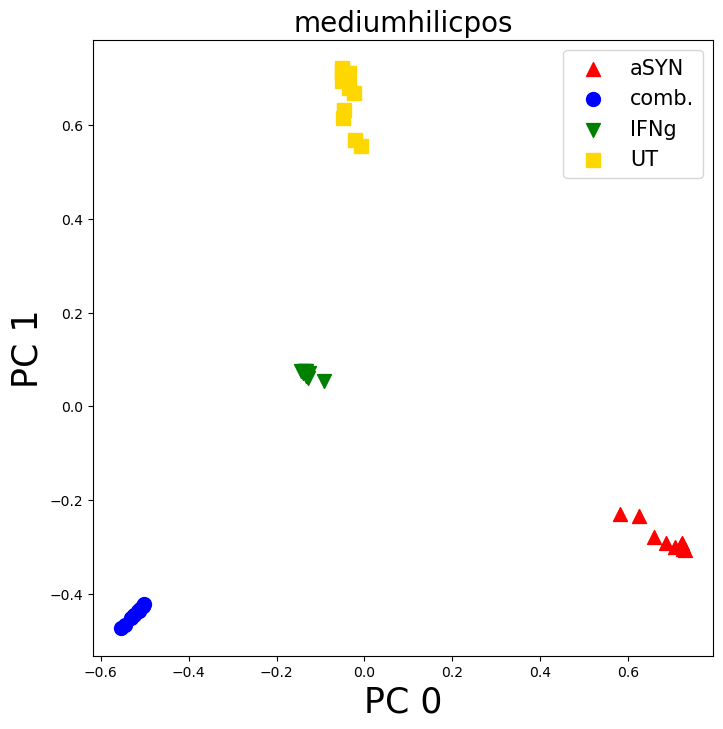

In [57]:
SAVE=False
INCLUDE_ID=False

tle1 = filenamesGF[fnum].split('GF')[0]

#pca = PCA().fit_transform(x1)
#pca = FactorAnalysis().fit_transform(x1)
pca = KernelPCA(n_components=3, kernel='precomputed').fit_transform(K)
#pca = add_noise(pca, 1)
assert(x1.shape[0]==40==pca.shape[0])
k=0
kk=1
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pca[:10,k],pca[:10,kk], marker='^', c='red', s=100)
ax.scatter(pca[10:20,k],pca[10:20,kk], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,k],pca[20:30,kk], marker='v', c='green', s=100)
ax.scatter(pca[30:,k],pca[30:,kk], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','IFNg','UT'], fontsize=15)

if INCLUDE_ID:
    for i, txt in enumerate(ID):
        ax.annotate(txt, (pca[i,k], pca[i,kk]),fontsize=12)

plt.xlabel('PC {}'.format(k), fontsize=25)
plt.ylabel('PC {}'.format(kk), fontsize=25)
plt.title(tle1, fontsize=20)
plt.show()

if SAVE:
    tle1 += '_PCA1vs{}'.format(k+1)
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle1))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle1))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle1))

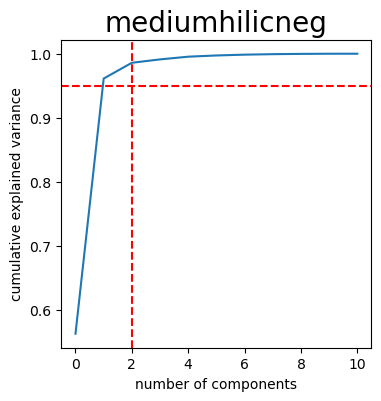

In [7]:
# plot explained variance
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.cumsum(PCA().fit(x1).explained_variance_ratio_))
# set vline at 95% variance and 2 components
ax.axvline(x=2, color='red', linestyle='--')
ax.axhline(y=0.95, color='red', linestyle='--')
ax.set_xlabel('number of components', fontsize=10)
ax.set_ylabel('cumulative explained variance', fontsize=10)
ax.set_title(tle1, fontsize=20)
plt.show()

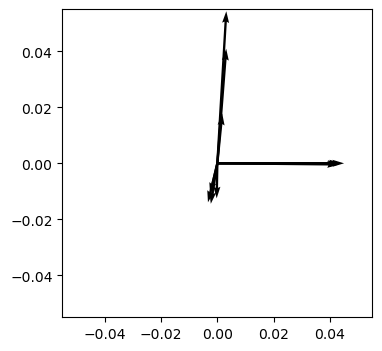

In [34]:
include_ids=False
fa = FactorAnalysis(n_components=2).fit(x1)
#fa = PCA().fit(x1)
# plot factor loadings with quiver plot
factor_loadings = fa.components_.T
#factor_loadings=add_noise(factor_loadings, .2)
# scale the loadings for visualization purposes
factor_loadings = factor_loadings
fig, ax = plt.subplots(figsize=(4,4))
ax.quiver(np.zeros(factor_loadings.shape[0]), np.zeros(factor_loadings.shape[0]),
            factor_loadings[:,0], factor_loadings[:,1],
            angles='xy', scale_units='xy', scale=50)

feature_names = significant_features.iloc[3:,0]
# name each arrow (feature), by feature name
if include_ids==True:
    for i,j,z in zip(factor_loadings[:,0], factor_loadings[:,1], feature_names):
        ax.annotate(z, xy=(i,j), fontsize=15)
        

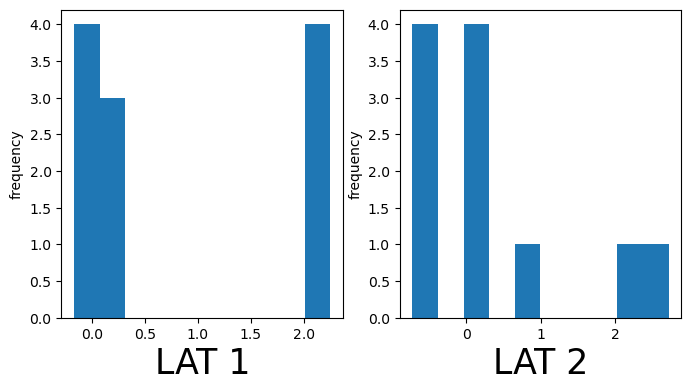

In [35]:
fig, ax = plt.subplots(1,2,figsize=(8,4)) 
ax[0].hist(factor_loadings.T[0,:])
ax[0].set_xlabel('LAT 1', fontsize=25)
ax[0].set_ylabel('frequency', fontsize=10)
ax[1].hist(factor_loadings.T[1,:])
ax[1].set_xlabel('LAT 2', fontsize=25)
ax[1].set_ylabel('frequency', fontsize=10)
plt.show()


In [14]:
fnum2=1
data2 = pd.read_csv(pathGF + filenamesGF[fnum2],sep=';', header=None)

df_significance2 = pd.read_csv(path_s + filenames_s[fnum2],sep=';')

masstime2 = np.unique(df_significance2[' masstime'].to_numpy())
significant_features2 = get_features(masstime2, data2, True)
x2 = significant_features2.iloc[3:,8:48].to_numpy(dtype=float).T
ID2=get_ids(data2.iloc[:,:48])

assert(np.all(ID2==ID))
print("{} significant features".format(len(masstime2)+len(masstime)))
x_1and2 = np.hstack((x1,x2))

62 significant features


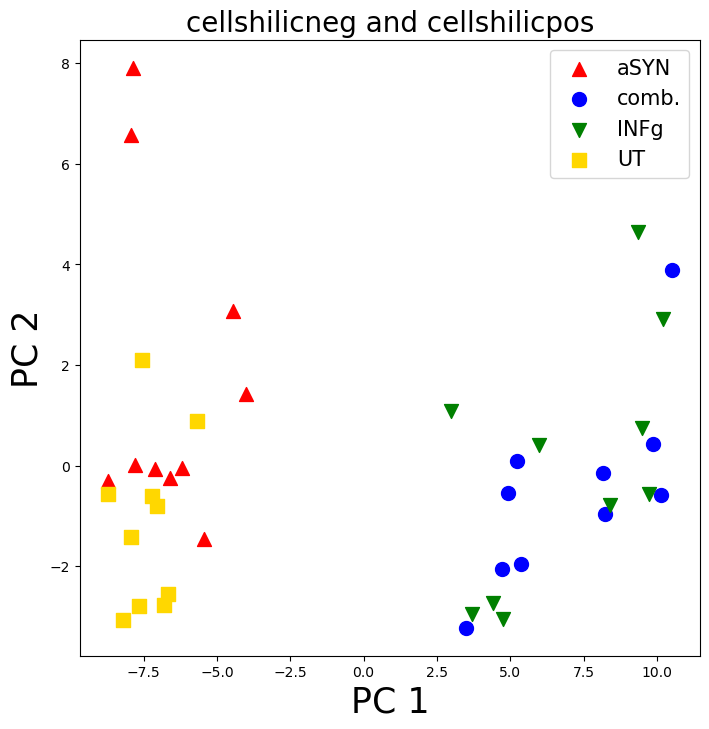

In [16]:
SAVE=False
INCLUDE_ID=False

tle2 = filenamesGF[fnum2].split('GF')[0]


pca = PCA().fit_transform(x_1and2)
#pca = add_noise(pca, 1)

k=1
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pca[:10,0],pca[:10,k], marker='^', c='red', s=100)
ax.scatter(pca[10:20,0],pca[10:20,k], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,0],pca[20:30,k], marker='v', c='green', s=100)
ax.scatter(pca[30:,0],pca[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','INFg','UT'], fontsize=15)

if INCLUDE_ID:
    for i, txt in enumerate(ID):
        ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=12)

plt.xlabel('PC 1', fontsize=25)
plt.ylabel('PC {}'.format(k+1), fontsize=25)
plt.title(tle1 + ' and ' + tle2, fontsize=20)
plt.show()

if SAVE:
    tle_combined = tle1 + '_and_{}_PCA1vs{}'.format(tle2,k)
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle_combined))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle_combined))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle_combined))

Stop at step 892


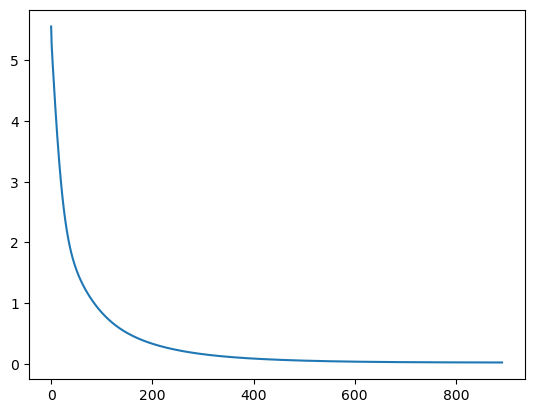

In [39]:
U_init, V_init = nnd_svd_initialization(x1, 4)
# ratings, U_init, V_init, n_iter=100, n_iter_inner=10, alpha=0.0002, beta=0.02, tol=1e-5
U, V, err = matrix_factorization(x1, U_init, V_init, 1000, 10, alpha=0.0002, beta=0.02, tol=1e-5)
plt.plot(err)

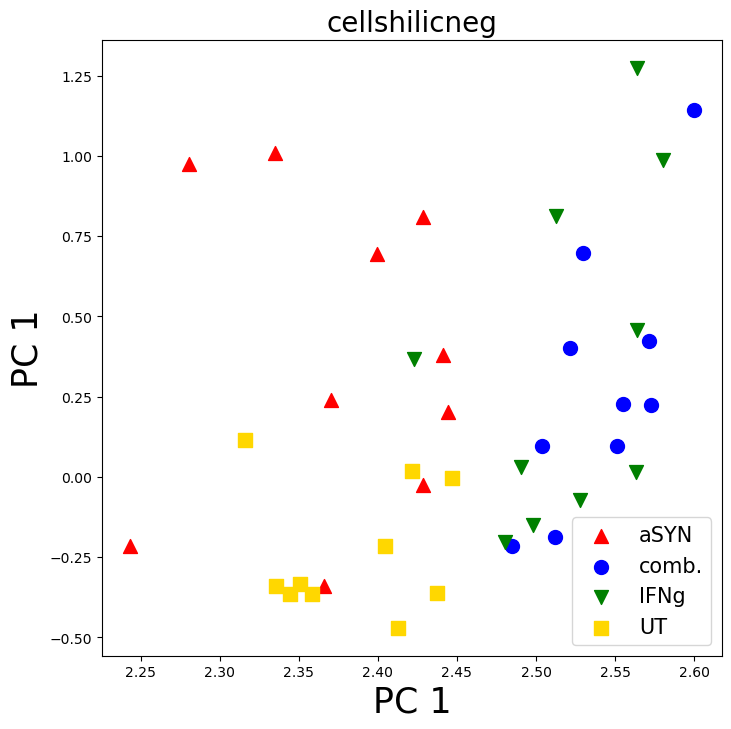

In [42]:
k=1
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(U[:10,0],U[:10,k], marker='^', c='red', s=100)
ax.scatter(U[10:20,0],U[10:20,k], marker='o', c='blue', s=100)
ax.scatter(U[20:30,0],U[20:30,k], marker='v', c='green', s=100)
ax.scatter(U[30:,0],U[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','IFNg','UT'], fontsize=15)

if INCLUDE_ID:
    for i, txt in enumerate(ID):
        ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=12)

plt.xlabel('PC 1', fontsize=25)
plt.ylabel('PC {}'.format(k), fontsize=25)
plt.title(tle1, fontsize=20)
plt.show()


### Get data from another mode

### Check GAP fill patterns

In [ ]:
fnum=0
pathGF = "../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
data = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

path_s = "../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_significance = pd.read_csv(path_s + filenames_s[fnum],sep=';')

masstime = np.unique(df_significance[' masstime'].to_numpy())
significant_features = get_features(masstime, data, True)
Area = significant_features.iloc[3:,8:48].to_numpy(dtype=float)
Area_all = data.iloc[3:,8:48].to_numpy(dtype=float)
ID=get_ids(data.iloc[:,:48])

GFcols = [i for i in range(0,significant_features.shape[1]) if i not in np.arange(8,88)]
GF=significant_features.iloc[:,GFcols]
gaps = GF.iloc[3:,8:48].to_numpy(dtype=int)
groups = data.iloc[0,8:48]
LE = LabelEncoder()
labels = LE.fit_transform(groups)
print("{} significant features".format(len(masstime)))

In [22]:
aSYN=GF.iloc[:,8:18]
comb=GF.iloc[:,18:28]
INFg=GF.iloc[:,28:38]
UT=GF.iloc[:,38:]

In [23]:
tol=10
token=8
inds=[]
ls=['aSYN','comb','INFg','UT']
for k, group in enumerate([aSYN,comb,INFg,UT]):
    for i in range(3,group.shape[0]):
        arr=np.asarray(group.iloc[i,:], dtype=int)
        s=np.sum(arr==token)
        if s>=tol:
            inds.append((ls[k],i))

### Get significant features by matching masstimes